<h3 style="font-family: Times New Roman"><strong>Training a Region Based CNN Model</strong></h3>

<div style="font-family: Times New Roman; font-size: 15px; text-align:justify">
A Convolutional Neural Network (CNN) with a fully connected layer struggles with handling multiple objects and varying occurrences, making brute-force sliding window approaches computationally expensive due to the need to consider various sizes and aspect ratios of objects within an image. To address this, Ross Girshick et al. proposed the R-CNN (Region-based CNN) architecture in 2013. R-CNN uses a selective search algorithm to generate approximately 2000 region proposals, which are then processed by a CNN to extract features. These features are classified by an SVM model, and a bounding box regressor is used to precisely localize objects within the image.
</div>

<h4 style="font-family: Times New Roman"><strong>Region Proposals</strong></h4>

<div style="font-family: Times New Roman; font-size: 15px; text-align:justify">
Region proposals are smaller sections of an image that potentially contain the objects of interest. To minimize the number of region proposals, R-CNN employs a greedy algorithm known as selective search.
</div>

<center><img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*tqkP5QNPAEgMUY0M5zvbrA.png" width="70%"></center>

<h4 style="font-family: Times New Roman"><strong>Selective Search</strong></h4>

<div style="font-family: Times New Roman; font-size: 15px; text-align:justify">
Selective search is a region proposal algorithm used in object detection to generate candidate regions within an image that are likely to contain objects of interest. It begins by segmenting the image into many small regions, which are then hierarchically grouped based on similarity in color, texture, size, and shape. A greedy algorithm iteratively merges these regions to form larger ones, producing region proposals at various scales and sizes. This approach yields a manageable number of high-quality region proposals, typically around 2000, making it a computationally efficient alternative to exhaustive sliding window methods and an effective preprocessing step for models like R-CNN.
</div>

<h4 style="font-family: Times New Roman"><strong>Faster RCNN vs Vanilla RCNN</strong></h4>

<div style="font-family: Times New Roman; font-size: 15px; text-align:justify">
In contrast to the vanilla R-CNN, Faster R-CNN significantly improves the efficiency and speed of the object detection process by introducing an integrated Region Proposal Network (RPN). The RPN is a fully convolutional network that shares convolutional layers with the detection network, enabling end-to-end training. This network generates region proposals more efficiently than the selective search used in R-CNN. Faster R-CNN alternates between training the RPN and the Fast R-CNN detector, sharing convolutional computations and allowing for faster convergence. The shared feature extraction process and integrated proposal generation make Faster R-CNN much faster and more efficient compared to the original R-CNN, without sacrificing detection accuracy.
</div>

<center>
    <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*WJsEQnhr4puR4k-29uD80Q.png" width="50%">
</center>

<h4 style="font-family: Times New Roman"><strong>Import Standard Libraries</strong></h4>

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms as T

import os
from tqdm.notebook import tnrange, tqdm_notebook
import cv2
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

from scripts import tools
from scripts import custom_transforms as CT

<div style="font-family: Times New Roman; font-size: 15px">
For this demonstration, we will be using a fruit dataset. It includes 331 images. Fruits are annotated in YOLO v5 PyTorch format.
<br><br>
The following pre-processing was applied to each image:
<ul>
    <li>Auto-orientation of pixel data (with EXIF-orientation stripping)</li>
    <li>Resize to 640x640 (Stretch)</li>
</ul>
The following augmentation was applied to create 3 versions of each source image:
<ul>
    <li>50% probability of horizontal flip</li>
    <li>Random rotation of between -45 and +45 degrees</li>
</ul>
</div>

<div style="font-family: Times New Roman; font-size: 15px">
YOLO V5 dataset is usually saved in this manner:
<br>
<center>
    <img src="figures/yolov5_dir.jpg" width="50%">
</center>
The <strong><tt>images<tt></strong> folder in both train and test contains images in <strong><tt>jpg</tt></strong> format. The <strong><tt>labels</tt></strong> contains txt files for the annotation, each having [class, x-center, y-center, box-width, box-height]. Each instance have the same name for the image and annotation except the extension (txt, jpg).
</div>

In [2]:
# define where the dataset is being stored
root = 'data/fruits'

<div style="font-family: Times New Roman; font-size: 15px; text-align:justify">
    In PyTorch, a custom dataset is a user-defined class that extends the <strong><tt>torch.utils.data.Dataset</tt></strong> class, allowing for the loading and preprocessing of data in a flexible and tailored manner. This custom dataset class typically implements two key methods: <strong><tt>__len__()</tt></strong> and <strong><tt>__getitem__()</tt></strong>. The <strong><tt>__len__()</tt></strong> method returns the size of the dataset, while the <strong><tt>__getitem__()</tt></strong> method retrieves a single data point, often returning a tuple containing the input data (e.g., image) and its corresponding label. Custom datasets are particularly useful when dealing with non-standard data formats or when additional preprocessing steps are needed before feeding data into a model. By defining a custom dataset, users can leverage PyTorch's powerful data loading utilities, such as <strong><tt>DataLoader</tt></strong>, which facilitate efficient data handling and batching during training and evaluation.
</div>

In [3]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, subset, image_transform=None, label_transform=None):
        self.root_dir = os.path.join(root_dir, subset)
        self.image_transform = image_transform
        self.label_transform = label_transform
        self.image_files = sorted([f for f in os.listdir(os.path.join(self.root_dir, 'images')) if f.endswith('.jpg')])
        self.label_files = sorted([f for f in os.listdir(os.path.join(self.root_dir, 'labels')) if f.endswith('.txt')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, 'images', self.image_files[idx])
        label_path = os.path.join(self.root_dir, 'labels', self.label_files[idx])

        image = tools.load_img(image_path)
        label = tools.ParseYolo(label_path, size=image.shape[:2]).load_txt()

        if self.image_transform and self.label_transform:
            image = self.image_transform(image)
            label = self.label_transform(label)
            return image, label

        return image, label

<h4 style="font-family: Times New Roman"><strong>Instantiating the Dataset Object</strong></h4>

<div style="font-family: Times New Roman; font-size: 15px; text-align:justify">
The <strong><tt>Dataset</tt></strong> class in PyTorch manages individual data instances, where each instance of the <strong><tt>Dataset</tt></strong> class is iterable and supports indexing. Additionally, the <strong><tt>Dataset</tt></strong> class can take a <strong><tt>transforms</tt></strong> parameter, which is a <strong><tt>callable</tt></strong> or a <strong><tt>list</tt></strong> of <strong><tt>transform functions</tt></strong> applied to each data instance. These transformations are used for preprocessing and data augmentation.
</div>


In [4]:
# instantiate dataset object
tools.set_seed(42)
height, width = 640, 640

img_trans = T.Compose([
    T.ToTensor(),
    T.Resize(size=(height, width))
])

lbl_trans = T.Compose([
    CT.ResizeBbox(size=(height, width))
])

train_set = CustomDataset(root, 'train', img_trans, lbl_trans)
test_set = CustomDataset(root, 'valid', img_trans, lbl_trans)

train_size = int(len(train_set) * 0.7)
val_size = len(train_set) - train_size

train_set, val_set = random_split(train_set, [train_size, val_size])

<h4 style="font-family: Times New Roman"><strong>Instantiating the DataLoader Objects</strong></h4>

<div style="font-family: Times New Roman; font-size: 15px">
The <strong><tt>DataLoader</tt></strong> class in PyTorch is used to load data in batches and provides various options for customization. Key parameters include:

<ul>
    <li><strong><tt>shuffle</tt></strong>: A <strong><tt>boolean</tt></strong> parameter that, when set to <strong><tt>True</tt></strong>, shuffles the data at the beginning of each epoch. This is useful for improving the robustness of the model.</li>
    <li><strong><tt>batch_size</tt></strong>: An <strong><tt>integer</tt></strong> parameter that defines the number of samples to be loaded per batch. It determines how many samples are processed together before the model's weights are updated.</li>
    <li><strong><tt>collate_fn</tt></strong>: A <strong><tt>function</tt></strong> parameter that specifies how to merge a list of data samples into a single batch. It allows for custom processing of the data during batching.</li>
</ul>
</div>

In [6]:
tools.set_seed(42)
batch_size = 16
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size, collate_fn=tools.collate_fn)
val_loader = DataLoader(val_set, shuffle=False, batch_size=batch_size, collate_fn=tools.collate_fn)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size, collate_fn=tools.collate_fn)

<div style="font-family: Times New Roman; font-size: 15px">
Train Instances: <strong><tt>329</tt></strong>

<ul>
    <li><strong><tt>Test Size</tt></strong>: <strong><tt>2</tt></strong></li>
    <li><strong><tt>Train Size</tt></strong>: <strong><tt>230</tt></strong></li>
    <li><strong><tt>Validation Size</tt></strong>: <strong><tt>99</tt></strong></li>
    <li><strong><tt>Batch Size</tt></strong>: <strong><tt>4</tt></strong></li>
</ul>

The <strong><tt>Train Subset</tt></strong> is batched with <strong><tt>4</tt></strong> instances each, so $\frac{230}{4} = 57.5$. Thus, for each epoch during training, the model will process <strong><tt>58</tt></strong> batches. After each training epoch, the model will also traverse the <strong><tt>Validation Set</tt></strong>, which will be divided into the same batch size, resulting in <strong><tt>25</tt></strong> batches.
</div>

<h4 style="font-family: Times New Roman"><strong>Visualizing a Batch</strong></h4>

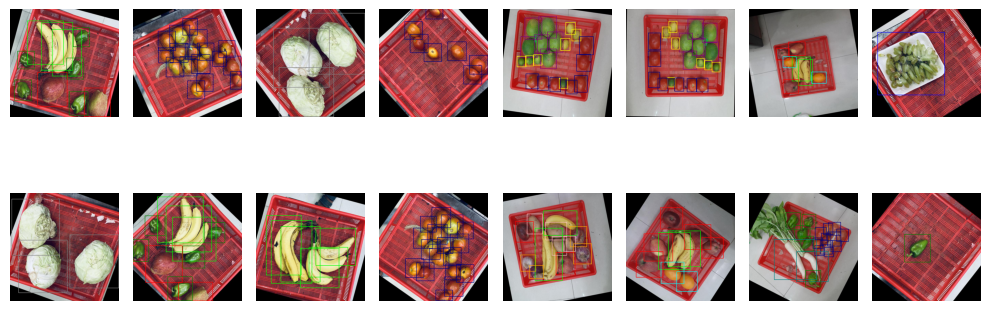

In [9]:
mapping = {
    0: (255, 0, 0),      # Apple                Red
    1: (0, 255, 0),      # Banana                Green
    2: (0, 0, 255),      # Grape                Blue
    3: (255, 255, 0),    # Lemon                Yellow
    4: (255, 165, 0),    # Onion                Orange
    5: (128, 0, 128),    # Orange green                Purple
    6: (0, 255, 255),    # Orange ripe                Cyan
    7: (255, 192, 203),  # Potato                Pink
    8: (128, 128, 128),  # Cabbage                Gray
    9: (0, 128, 0),      # Capsicum                Dark Green
    10: (128, 0, 0),     # Garlic                Maroon
    11: (0, 128, 128),   # Raddish                Teal
    12: (0, 0, 128)     # Tomato                Navy
}
tools.set_seed(42)
x, y = next(iter(train_loader))

tools.visualize_batch(x, y, mapping=mapping, subplot_dim=(2,8), figsize=(10, 5))

<h4 style="font-family: Times New Roman"><strong>Instantiate and Modify RCNN Model</strong></h4>

<div style="font-family: Times New Roman; font-size: 15px; text-align:justify">
The following code initializes a random seed using <strong><tt>tools.set_seed(42)</tt></strong> to ensure reproducibility. It then creates a <strong><tt>Faster R-CNN</tt></strong> model with a ResNet-50 backbone and Feature Pyramid Networks (FPN) using <strong><tt>fasterrcnn_resnet50_fpn(weights=True)</tt></strong>. The number of output classes is set to <strong><tt>13</tt></strong>. The code retrieves the number of input features for the classifier from the model’s region-of-interest (ROI) heads using <strong><tt>model.roi_heads.box_predictor.cls_score.in_features</tt></strong>, and replaces the default box predictor with a new <strong><tt>FastRCNNPredictor</tt></strong> that has the appropriate number of <strong><tt>in_features</tt></strong> and <strong><tt>num_classes</tt></strong>.
</div>


In [10]:
tools.set_seed(42)
model = fasterrcnn_resnet50_fpn(weights=True)
num_classes = 13
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

C:\Users\Brian\anaconda3\envs\dl_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<h4 style="font-family: Times New Roman"><strong>Instantiate Optimizer</strong></h4>

<div style="font-family: Times New Roman; font-size: 15px; text-align:justify">
This line of code creates a list of parameters with gradients enabled by using <strong><tt>[p for p in model.parameters() if p.requires_grad]</tt></strong>. It then initializes an <strong><tt>Adam optimizer</tt></strong> from <strong><tt>torch.optim</tt></strong>, passing in these parameters and setting the learning rate to <strong><tt>0.001</tt></strong> with <strong><tt>torch.optim.Adam(params, lr=0.001)</tt></strong>.
</div>


In [11]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001)

<h4 style="font-family: Times New Roman"><strong>Training Loop</strong></h4>

<div style="font-family: Times New Roman; font-size: 15px; text-align:justify">
In this training loop, the model is trained over <strong><tt>5 epochs</tt></strong>, with performance evaluated at the end of each epoch. During evaluation, the model’s predictions are visualized, allowing us to observe improvements in accuracy and prediction quality as the number of epochs increases.
</div>

In [ ]:
tools.set_seed(42)
num_epochs = 5
device = 'cuda'if torch.cuda.is_available() else 'cpu'
step_back = 0.3
model.to(device)

for eidx, e  in enumerate(tnrange(num_epochs)):
    epoch_loss = 0.0
    model.train()
    for batch in tqdm_notebook(train_loader):
        images, targets = batch
        
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
        
        loss_dict = model(images, targets)
        batch_losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        batch_losses.backward()
        optimizer.step()

        epoch_loss += batch_losses.item()
        
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(tqdm_notebook(val_loader)):
            images, targets = batch
            
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
            
            result = model(images)
            if idx == (len(val_loader) - 2):
                threshold = float(torch.stack([res['scores'].max() - step_back for res in result]).mean().detach().cpu())
                print(f"Epoch {eidx + 1} | Threshold = {np.round(threshold, 2)}")
                tools.visualize_batch(images, result, figsize=(10,7), threshold=threshold, mapping=mapping, subplot_dim=(1,4))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

<div class="alert alert-block alert-success" style="font-family: Times New Roman">
    <h4><strong>Laboratory Activity</strong></h4>

<p style="font-family: Times New Roman; text-align: justify; font-size: 15px">
        <b>Instructions:</b> Provide a detailed explanation of the training and validation loop. For each line of code, describe the expected outputs, including their dimensions and data types. Ensure clarity in how these outputs contribute to the overall process of training and evaluating the model.
</p>
</div>

<h4 style="font-family: Times New Roman"><strong>Inference Testing</strong></h4>

<div style="font-family: Times New Roman; font-size: 15px; text-align:justify">
In the test data predictions, some objects were not detected by the model with the current threshold of <strong><tt>50%</tt></strong>. Lowering the threshold results in a substantial increase in the number of predicted bounding boxes; however, these additional predictions tend to have lower confidence scores.
</div>


In [ ]:
with torch.no_grad():
    for idx, batch in enumerate(tqdm_notebook(test_loader)):
        images, targets = batch
        
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

        result = model(images)
        print("Predicted")
        tools.visualize_batch(images, result, threshold=0.5, figsize=(5,7), mapping=mapping, subplot_dim=(1,2))


print("Ground Truth")
tools.visualize_batch(images, targets, threshold=0.5, figsize=(5,7), mapping=mapping, subplot_dim=(1,2))

<h4 style="font-family: Times New Roman"><strong>Conclusion</strong></h4>

<div style="font-family: Times New Roman; font-size: 15px; text-align:justify">
In conclusion, using the <strong><tt>Faster R-CNN</tt></strong> model with <strong><tt>13 outputs</tt></strong>, <strong><tt>Adam</tt></strong> optimizer, a <strong><tt>batch size</tt></strong> of <strong><tt>4</tt></strong>, and an <strong><tt>image size</tt></strong> of <strong><tt>640x640</tt></strong> sensible results given. However, with an inference threshold of <strong><tt>0.5</tt></strong>, some objects, such as <strong><tt>green oranges</tt></strong> and <strong><tt>onions</tt></strong>, were not detected, indicating that adjustments in the model or threshold might be needed to improve detection accuracy.
</div>


<div class="alert alert-block alert-success" style="font-family: Times New Roman">
    <h4><strong>Laboratory Activity</strong></h4>

<p style="font-family: Times New Roman; text-align: justify; font-size: 15px; text-align:justify">
        <b>Instructions:</b> Enhance the model’s performance by adjusting key parameters such as <strong><tt>batch size</tt></strong>, <strong><tt>optimizer</tt></strong>, and <strong><tt>number of epochs</tt></strong>. Evaluate the impact of these changes on the model’s accuracy and efficiency. Maybe you could also further improve the model by examining the dataset.
</p>
</div>
